# Twitter API with Python

In [13]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
from textblob import TextBlob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import credential

In [14]:
# TWITTER CLIENT #
class TwitterClient():
    def __init__(self,twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth) #Twitter API wrapper
        self.twitter_user = twitter_user

    # Extract the data from tweets we get
    def get_twitter_client_api(self):
        return self.twitter_client

    # Returns the 20 most recent statuses posted from the authenticating user or the user specified.
    def get_user_timeline_tweets(self,num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self,num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list

    # Returns the 20 most recent statuses posted by the authenticating user and that user’s friends.
    def get_home_timeline_tweets(self,num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

# TWITTER AUTHENTICATER #
class TwitterAuthenticator():
    def authenticate_twitter_app(self):
        auth = OAuthHandler(credential.CONSUMER_KEY, credential.CONSUMER_SECRET)
        auth.set_access_token(credential.ACCESS_TOKEN,credential.ACCESS_TOKEN_SECRET)
        return auth

# TWITTER STREAMER #
# Class for streaming and processing live tweets
class TwitterStreamer():
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()

    # Method for handling twitter authentification and the connection to twitter streaming API
    def stream_tweets(self,fetched_tweets_filename,hash_tag_list):
        listener = TwitterListener(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
        stream = Stream(auth,listener)

        # filter twitter streams to capture data by the keywords
        stream.filter(track=hash_tag_list)

# TWITTER STREAM LISTENER #
# Basic listener that prints recived tweets to file
class TwitterListener(StreamListener):
    def __init__(self,fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

# Write the data on a file
    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename,'a')as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" %str(e))
            return True

    def on_error(self, status):
        # Returning False on_data method in case rate limit occurs
        if status == 420:
            return False
        print(status)

class TweetAnalyzer():
    # Function for analyzing and categorizing content from tweets.

    # Clean the tweet and remove any hyperlinks or extra charachters
    def clean_tweet(self,tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    # Tell whether the tweet is positive or negative
    def analyze_sentiment(self,tweet):
        analysis = TextBlob(self.clean_tweet(tweet))

        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1


    def tweets_to_data_frame(self,tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets],columns=['tweets'])

        df['id']=np.array([tweet.id for tweet in tweets])
        df['len']=np.array([len(tweet.text) for tweet in tweets])
        df['date']=np.array([tweet.created_at for tweet in tweets])
        df['source']=np.array([tweet.source for tweet in tweets])
        df['likes']=np.array([tweet.favorite_count for tweet in tweets])
        df['retweets']=np.array([tweet.retweet_count for tweet in tweets])

        return df

In [15]:
# # Streaming tweets # #
hash_tag_list=["donal trump","hillary clinton","barack obama","bernie sanders"]
fetched_tweets_filename="tweets.txt"

In [ ]:
twitter_streamer = TwitterStreamer()
twitter_streamer.stream_tweets(fetched_tweets_filename,hash_tag_list)

In [11]:
# Cursor and pagination # #
twitter_client = TwitterClient('pycon')
print(twitter_client.get_friend_list(10))

[User(_api=<tweepy.api.API object at 0x0000024B94FE0198>, _json={'id': 863550314, 'id_str': '863550314', 'name': 'Emily Morehouse-Valcarcel', 'screen_name': 'emilyemorehouse', 'location': 'Denver, CO', 'description': 'Director of Engineering @Cuttlesoft. Python core developer. Lover of programming languages. @PyCon 2019 co-chair, 202{0,1} chair. Wife, fur mama. 🦑👩🏻\u200d💻🐍🐺', 'url': 'https://t.co/oRQK2QNESM', 'entities': {'url': {'urls': [{'url': 'https://t.co/oRQK2QNESM', 'expanded_url': 'https://emilyemorehouse.com', 'display_url': 'emilyemorehouse.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 3222, 'friends_count': 547, 'listed_count': 88, 'created_at': 'Fri Oct 05 19:23:13 +0000 2012', 'favourites_count': 3673, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': False, 'statuses_count': 1559, 'lang': None, 'status': {'created_at': 'Wed Jul 24 14:30:58 +0000 2019', 'id': 1154036252884312064, 'id_str': '115403625

In [16]:
# Analyzing data # #
twitter_client = TwitterClient()
tweet_analyzer = TweetAnalyzer()

api = twitter_client.get_twitter_client_api()
tweets = api.user_timeline(screen_name="realDonaldTrump",count=200)

df = tweet_analyzer.tweets_to_data_frame(tweets)

print(df.head(10))

                                              tweets                   id  \
0  ....The flags at the White House will be lower...  1158102732085108736   
1  Today, I authorized the lowering of the flags ...  1158102730696736768   
2  God bless the people of El Paso, Texas. God bl...  1158099851248377856   
3  The FBI, local and state law enforcement are w...  1157987941182033920   
4  ....Melania and I send our heartfelt thoughts ...  1157868519964499968   
5  Today’s shooting in El Paso, Texas, was not on...  1157868518823596032   
6  'God be with you all': Trump pledges full supp...  1157757443901972480   
7  RT @i24NEWS_EN: There is nothing racist about ...  1157755915283718145   
8  Pastor Scott, a great guy - and tough! https:/...  1157755353876107270   
9  RT @PastorDScott: Contrary to what the Left's ...  1157754118917828608   

   len                date              source   likes  retweets  
0  140 2019-08-04 19:49:42  Twitter for iPhone   47494      8650  
1  140 2019-08-04 

In [17]:
# Print out information could be extracted from the first tweets
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


In [18]:
# Get average length over all tweets
print(np.mean(df['len']))

115.28643216080403


In [22]:
# Get the number of retweets for the most retweeted tweet
print(np.max(df['retweets']))

250472


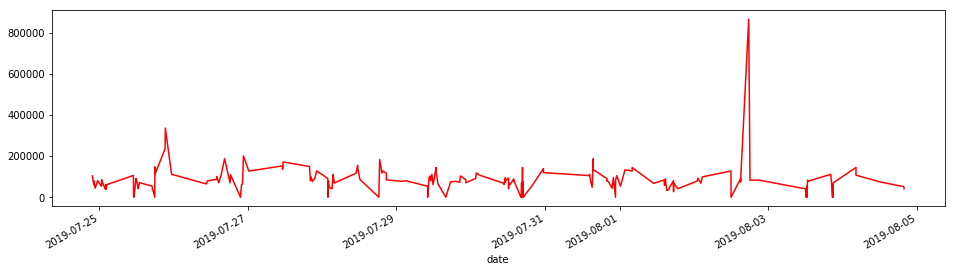

In [25]:
# # Visualzing data # #
# Time series
time_likes = pd.Series(data=df['likes'].values,index=df['date'])
time_likes.plot(figsize=(16,4),color='r')
plt.show()

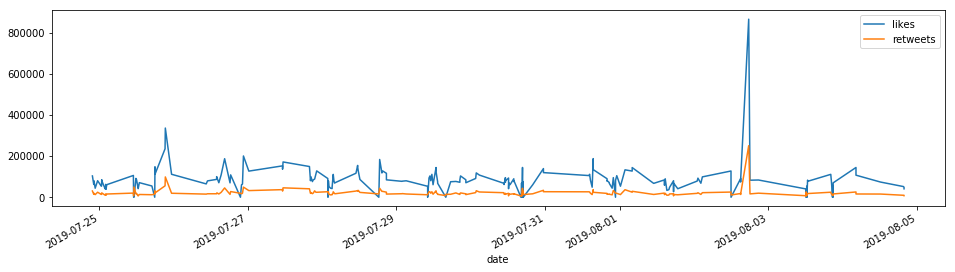

In [27]:
# Layered time series
time_likes = pd.Series(data=df['likes'].values,index=df['date'])
time_likes.plot(figsize=(16,4),label="likes",legend=True)

time_retweets = pd.Series(data=df['retweets'].values,index=df['date'])
time_retweets.plot(figsize=(16, 4), label="retweets", legend=True)

plt.show()

In [29]:
# See the tweet with highest likes and retweets
df1 = df.set_index(df['likes'])
df2 = df1.sort_index(ascending=False)
pd.set_option('display.max_colwidth',200)
print(df2.head(1).tweets)

likes
865555    A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!
Name: tweets, dtype: object


In [32]:
# # Sentiment analysis # #
df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
print(df.head(10))

                                                                                                                                         tweets                   id  len                date  \
0  ....The flags at the White House will be lowered today through Thursday, August 8. Melania and I are praying for al… https://t.co/3LtJlWada4  1158102732085108736  140 2019-08-04 19:49:42   
1  Today, I authorized the lowering of the flags to half-staff at all Federal Government buildings in honor of the vic… https://t.co/IgDFEyGquV  1158102730696736768  140 2019-08-04 19:49:42   
2                                                                 God bless the people of El Paso, Texas. God bless the people of Dayton, Ohio.  1158099851248377856   77 2019-08-04 19:38:15   
3  The FBI, local and state law enforcement are working together in El Paso and in Dayton, Ohio. Information is rapidl… https://t.co/2e55C7Amlo  1157987941182033920  140 2019-08-04 12:13:34   
4                                  

In [84]:
# Calculate the sentiment percentage
count=df['sentiment'].value_counts()

print("Percentage of positive tweets: {:.4}%".format(count[1]*100/len(df['tweets'])))
print("Percentage of neutral tweets: {:.4}%".format(count[0]*100/len(df['tweets'])))
print("Percentage de negative tweets: {:.4}%".format(count[-1]*100/len(df['tweets'])))

Percentage of positive tweets: 42.21%
Percentage of neutral tweets: 34.67%
Percentage de negative tweets: 23.12%


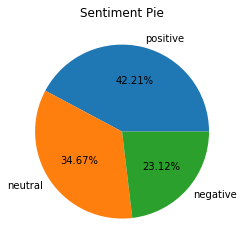

In [86]:
# Visualize the sentiment percentage
labels=['positive','neutral','negative']
X=[count[1],count[0],count[-1]]  
 
fig = plt.figure()
plt.pie(X,labels=labels,autopct='%1.2f%%',radius=1) 
plt.title("Sentiment Pie")
 
plt.show()